# Uczenie Maszynowe - projekt

### Etap 2

- Tomasz Owienko
- Wojciech Zarzecki

### Cel projektu

Celem projektu jest implementacja zmodyfikowanej wersji algorytmu generowania lasu losowego, w której do generowania kolejnych drzew losowane są częściej elementy ze zbioru uczącego, na których dotychczasowy model się mylił.

Istotą metody lasu losowego w problemach regresji i klasyfikacji jest redukcja wariancji i nadmiernego dopasowania osiąganego przez pojedyncze drzewa decyzyjne. W klasycznych algorytmach generowania lasu losowego każde z $B$ drzew generowane jest na podstawie $\sqrt{B}$ przykładów ze zbioru trenującego wylosowanych ze zwracaniem, zazwyczaj ograniczonych (w problemach klasyfikacji) do $\sqrt{|D|}$ atrybutów wylosowanych bez zwracania, gdzie $D$ jest zbiorem atrybutów. Proces ten odbywa się w jednej iteracji - algorytm kończy pracę po wygenerowaniu $B$ drzew. Taka koncepcja to tzw. \textit{bagging}, który ma na celu ograniczenie wariancji modelu po przez agreację wielu prostszych modeli - w tym przypadku drzew decyzyjnych.

Realizowany projekt zakłada zbadanie możliwości zastosowania metod \textit{boostingu} oraz \textit{stackingu}. Wdrożenie metod boostingowych polega na uwzględnianiu błędów wygenerowanych już drzew decyzyjnych przy budowanie kolejnych. W takim podejściu nowe drzewa są nieustannie dołączane są do istniejącego już lasu. Natomiast stacking zakłada utworzenie nowego zbioru danych na bazie wyników wytrenowanego modelu oraz wytrenowanie na nowym zbiorze \textit{metamodelu}. Co istotne, w podejściu stackingowym las wygenerowany w iteracji $n+1$ w pełni zastępuje las z iteracji $n$.


### Opis algorytmu

Algorytm korzystający z boostingu - przykłady wykorzystywane do generowania kolejnych drzew losowane są z preferencjami dla tych przykładów, dla których pojedyncze drzewa najczęściej się myliły. Wagi przykładów odwrotnie są proporcjonalne do dokładności predykcji na nich:

<wstawić obrazki>

### Wykorzystywane zbiory danych

Ocena jakości modeli wykonywana była w oparciu o dwa zbiory danych:

- UCI Breast Cancer - 569 przykładów, 31 atrybutów numerycznych ciągłych
- UCI Spambase - 4601 przykładów, 57 atrybutów ciągłych i dyskretnych
- UCI Statlog (German Credit Data) - 1000 przykładów, 20 atrybutów dyskretnych, kategoryzacyjnych i binarnych


In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np

In [22]:
breast_cancer = fetch_ucirepo(id=17)
breast_cancer_features_df = pd.DataFrame.from_dict(breast_cancer['data']['features'])
breast_cancer_classes_df = pd.DataFrame.from_dict(breast_cancer['data']['targets'])
pd.concat([breast_cancer_classes_df, breast_cancer_features_df], axis=1)

,Diagnosis,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [2]:
spambase = fetch_ucirepo(id=94)
spambase_features_df = pd.DataFrame.from_dict(spambase['data']['features'])
spambase_classes_df = pd.DataFrame.from_dict(spambase['data']['targets'])
pd.concat([spambase_classes_df, spambase_features_df], axis=1)

,Class,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,...,word_freq_conference,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total
0,1,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,...,0.0,0.000,0.000,0.0,0.778,0.000,0.000,3.756,61,278
1,1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,...,0.0,0.000,0.132,0.0,0.372,0.180,0.048,5.114,101,1028
2,1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,...,0.0,0.010,0.143,0.0,0.276,0.184,0.010,9.821,485,2259
3,1,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,...,0.0,0.000,0.137,0.0,0.137,0.000,0.000,3.537,40,191
4,1,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,...,0.0,0.000,0.135,0.0,0.135,0.000,0.000,3.537,40,191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4596,0,0.31,0.00,0.62,0.0,0.00,0.31,0.00,0.00,0.00,...,0.0,0.000,0.232,0.0,0.000,0.000,0.000,1.142,3,88
4597,0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.000,0.000,0.0,0.353,0.000,0.000,1.555,4,14
4598,0,0.30,0.00,0.30,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.102,0.718,0.0,0.000,0.000,0.000,1.404,6,118
4599,0,0.96,0.00,0.00,0.0,0.32,0.00,0.00,0.00,0.00,...,0.0,0.000,0.057,0.0,0.000,0.000,0.000,1.147,5,78


In [3]:
statlog = fetch_ucirepo(id=144)
statlog_features_df = pd.DataFrame.from_dict(statlog['data']['features'])
statlog_classes_df = pd.DataFrame.from_dict(statlog['data']['targets'])
pd.concat([statlog_classes_df, statlog_features_df], axis=1)

,class,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,...,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,1,A11,6,A34,A43,1169,A65,A75,4,A93,...,4,A121,67,A143,A152,2,A173,1,A192,A201
1,2,A12,48,A32,A43,5951,A61,A73,2,A92,...,2,A121,22,A143,A152,1,A173,1,A191,A201
2,1,A14,12,A34,A46,2096,A61,A74,2,A93,...,3,A121,49,A143,A152,1,A172,2,A191,A201
3,1,A11,42,A32,A42,7882,A61,A74,2,A93,...,4,A122,45,A143,A153,1,A173,2,A191,A201
4,2,A11,24,A33,A40,4870,A61,A73,3,A93,...,4,A124,53,A143,A153,2,A173,2,A191,A201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,A14,12,A32,A42,1736,A61,A74,3,A92,...,4,A121,31,A143,A152,1,A172,1,A191,A201
996,1,A11,30,A32,A41,3857,A61,A73,4,A91,...,4,A122,40,A143,A152,1,A174,1,A192,A201
997,1,A14,12,A32,A43,804,A61,A75,4,A93,...,4,A123,38,A143,A152,1,A173,1,A191,A201
998,2,A11,45,A32,A43,1845,A61,A73,4,A93,...,4,A124,23,A143,A153,1,A173,1,A192,A201


# Las losowy z wykorzystaniem boostingu


### Implementacja

Zaimplementowano algorytm generowania lasu losowego z wykorzystaniem boostigu zgodnie z przedstawionym wyżej opisem. Wykorzystano podobieństwo implementowanej metody do algorytmu AdaBoost, który również zakłada iteracyjne generowanie pojedynczych klasyfikatorów (_weak learner_) losując do ich trenowania te przykłady, na których model częściej się mylił, a następnie predykcję przez głosowanie. Wagą przykładu jest w tym wypadku udział błędnych predykcji na danym przykładzie we wszystkich predykcjach. Algorytm AdaBoost posiada dodatkowo mechanizm ważenia głosów - tutaj nieobecny. W takiej sytuacji model wygenerowany przez algorytm AdaBoost jest _de facto_ lasem losowym.

Skorzystano z implementacji klasyfikatora `AdaBoostClassifier` i wprowadzono dwie modyfikacje:
- pojednczym predyktorem (_weak learner_) jest drzewo decyzyjne dowolnej głębokości (w AdaBoost - najczęściej głębokości 1)
- wagi wszystkich głosów są równe

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier


class BoostedRFClassifier(AdaBoostClassifier):
    def __init__(
            self,
            *,
            estimator=DecisionTreeClassifier(),
            n_estimators=50,
            learning_rate=1.0,
            random_state=None,
            algorithm='SAMME',
            _disable_weights=True,
    ):
        super().__init__(
            estimator=estimator,
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            random_state=random_state,
            algorithm=algorithm
        )

        self._disable_weights = _disable_weights
        self._estimator_weights = np.zeros(self.n_estimators, dtype=np.float64)

    @property
    def estimator_weights_(self):
        return np.ones(self.n_estimators, dtype=np.float64) if self._disable_weights else self._estimator_weights

    @estimator_weights_.setter
    def estimator_weights_(self, v):
        if not self._disable_weights:
            self._estimator_weights = v

### Eksperymenty

Porównano jakość predykcji modeli w zależności od maksymalnej dozwolonej głębokości drzewa oraz liczby drzew tworzących las losowy. Zestawiono ze sobą boostingowy oraz klasyczny algorytm generowania lasu losowego. Do oceny wyników zastosowano pięciokrotną walidację krzyżową.

#### Porównanie względem maksymalnej głębokości drzewa

Przyjeto rozmiar lasu losowego $N=50$.

In [6]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from src.evaluation import evaluate

In [7]:
tree_depths = list(range(1, 33))
measures = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']

In [8]:
clf = RandomForestClassifier(n_estimators=200)

spambase_lb = LabelBinarizer()

spambase_features_df_encoded = spambase_features_df

encoded_features = spambase_features_df.columns
label_encoders = {feature: LabelEncoder() for feature in encoded_features}
for feature, encoder in label_encoders.items():
    spambase_features_df[feature] = encoder.fit_transform(spambase_features_df[feature])

X_spambase = spambase_features_df_encoded
y_spambase = np.squeeze(spambase_lb.fit_transform(spambase_classes_df))

In [9]:
res_spambase = [evaluate(BoostedRFClassifier(
    estimator=DecisionTreeClassifier(max_depth=depth),
    n_estimators=50,
    algorithm='SAMME',
    _disable_weights=True
), X_spambase, y_spambase, scoring=measures) for depth in tree_depths]
res_ref_spambase = [evaluate(RandomForestClassifier(
    max_depth=depth,
    n_estimators=50,
    n_jobs=8
), X_spambase, y_spambase, scoring=measures) for depth in tree_depths]

In [10]:
statlog_lb_labels = LabelBinarizer()

statlog_features_df_encoded = statlog_features_df

encoded_features = statlog_features_df.columns
label_encoders = {feature: LabelEncoder() for feature in encoded_features}
for feature, encoder in label_encoders.items():
    statlog_features_df[feature] = encoder.fit_transform(statlog_features_df[feature])

X_statlog = statlog_features_df_encoded
y_statlog = np.squeeze(statlog_lb_labels.fit_transform(statlog_classes_df))

In [11]:
res_statlog = [evaluate(BoostedRFClassifier(
    estimator=DecisionTreeClassifier(max_depth=depth),
    n_estimators=50,
    algorithm='SAMME',
    _disable_weights=True
), X_statlog, y_statlog, scoring=measures) for depth in tree_depths]
res_ref_statlog = [evaluate(RandomForestClassifier(
    max_depth=depth,
    n_estimators=50,
    n_jobs=8
), X_statlog, y_statlog, scoring=measures) for depth in tree_depths]

/home/tomek/.cache/pypoetry/virtualenvs/uma-Lru3vfTz-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tomek/.cache/pypoetry/virtualenvs/uma-Lru3vfTz-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/tomek/.cache/pypoetry/virtualenvs/uma-Lru3vfTz-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

In [23]:
breast_cancer_lb_labels = LabelBinarizer()

breast_cancer_features_df_encoded = breast_cancer_features_df

encoded_features = breast_cancer_features_df.columns
label_encoders = {feature: LabelEncoder() for feature in encoded_features}
for feature, encoder in label_encoders.items():
    breast_cancer_features_df[feature] = encoder.fit_transform(breast_cancer_features_df[feature])

X_breast_cancer = breast_cancer_features_df_encoded
y_breast_cancer = np.squeeze(breast_cancer_lb_labels.fit_transform(breast_cancer_classes_df))

In [24]:
res_breast_cancer = [evaluate(BoostedRFClassifier(
    estimator=DecisionTreeClassifier(max_depth=depth),
    n_estimators=50,
    algorithm='SAMME',
    _disable_weights=True
), X_breast_cancer, y_breast_cancer, scoring=measures) for depth in tree_depths]
res_ref_breast_cancer = [evaluate(RandomForestClassifier(
    max_depth=depth,
    n_estimators=50,
    n_jobs=8
), X_breast_cancer, y_breast_cancer, scoring=measures) for depth in tree_depths]

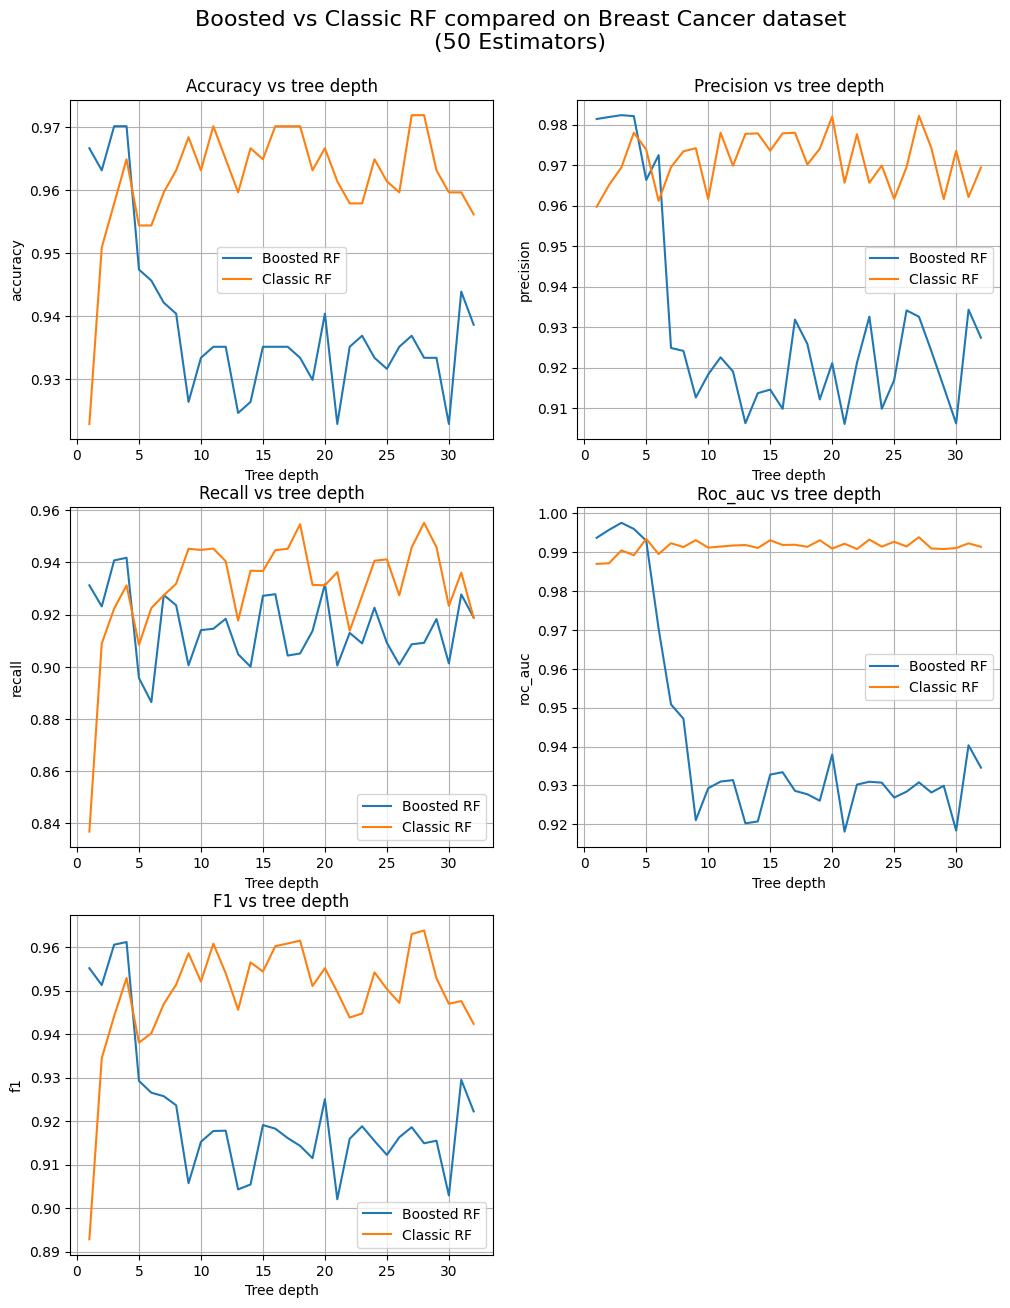

In [25]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(3, 2)
fig.set_size_inches(12, 15)
for measure, ax in zip(measures, axes.reshape(-1)):
    _y = [r[f"test_{measure}"] for r in res_breast_cancer]
    _y_ref = [r[f"test_{measure}"] for r in res_ref_breast_cancer]
    ax.plot(tree_depths, _y, label="Boosted RF")
    ax.plot(tree_depths, _y_ref, label="Classic RF")
    ax.set_xlabel("Tree depth")
    ax.set_ylabel(measure)
    ax.grid(True)
    ax.legend()
    ax.set_title(f"{measure.capitalize()} vs tree depth")
    fig.suptitle("Boosted vs Classic RF compared on Breast Cancer dataset\n(50 Estimators)", fontsize=16, y=0.94)

axes.reshape(-1)[-1].set_visible(False)

plt.show()

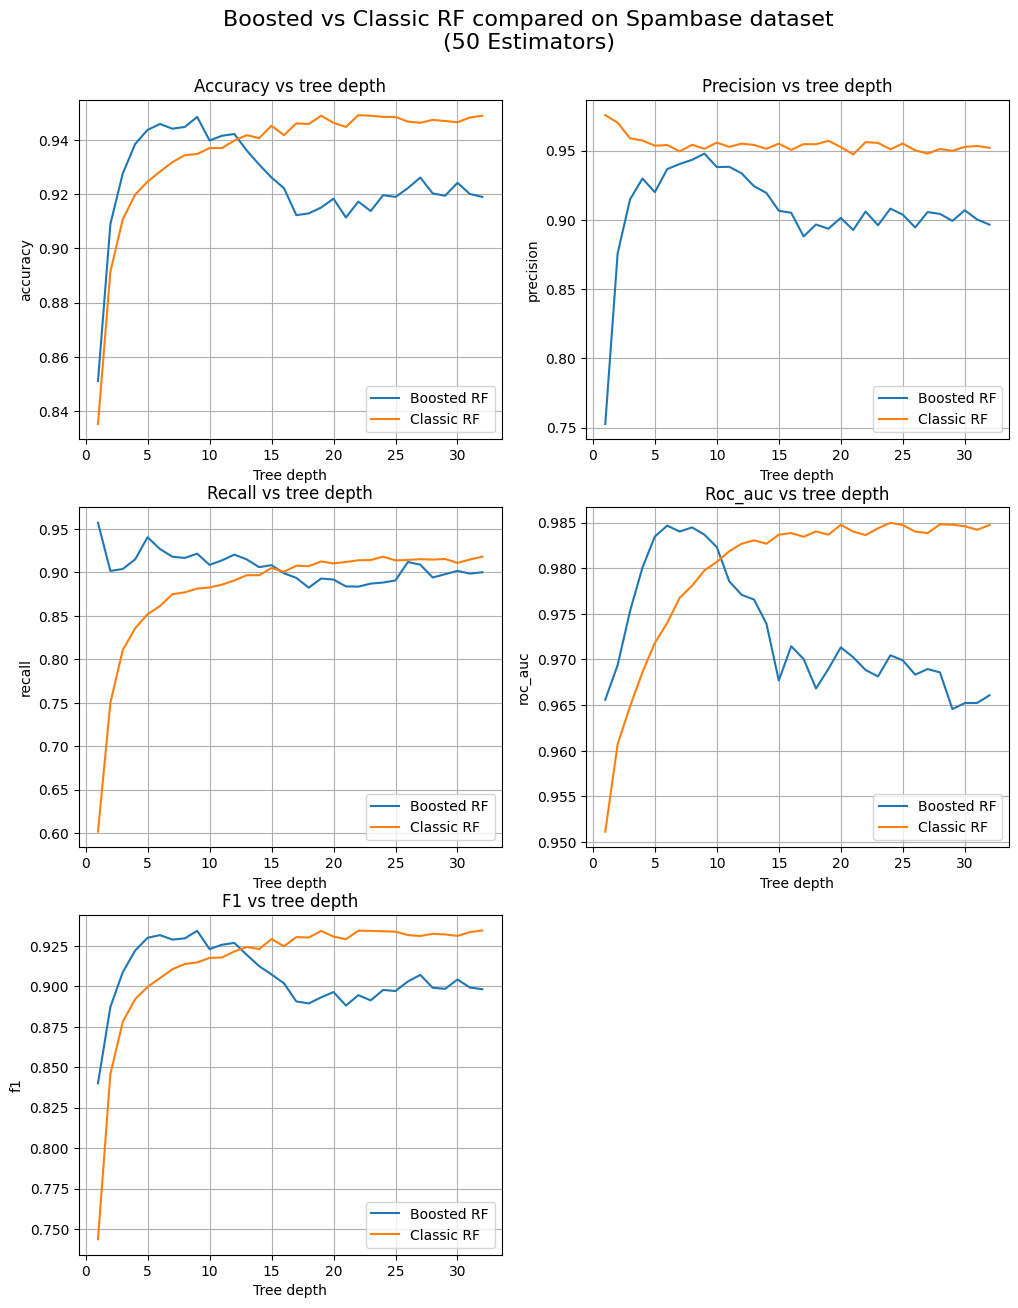

In [12]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(3, 2)
fig.set_size_inches(12, 15)
for measure, ax in zip(measures, axes.reshape(-1)):
    _y = [r[f"test_{measure}"] for r in res_spambase]
    _y_ref = [r[f"test_{measure}"] for r in res_ref_spambase]
    ax.plot(tree_depths, _y, label="Boosted RF")
    ax.plot(tree_depths, _y_ref, label="Classic RF")
    ax.set_xlabel("Tree depth")
    ax.set_ylabel(measure)
    ax.grid(True)
    ax.legend()
    ax.set_title(f"{measure.capitalize()} vs tree depth")

fig.suptitle("Boosted vs Classic RF compared on Spambase dataset\n(50 Estimators)", fontsize=16, y=0.94)

axes.reshape(-1)[-1].set_visible(False)

plt.show()


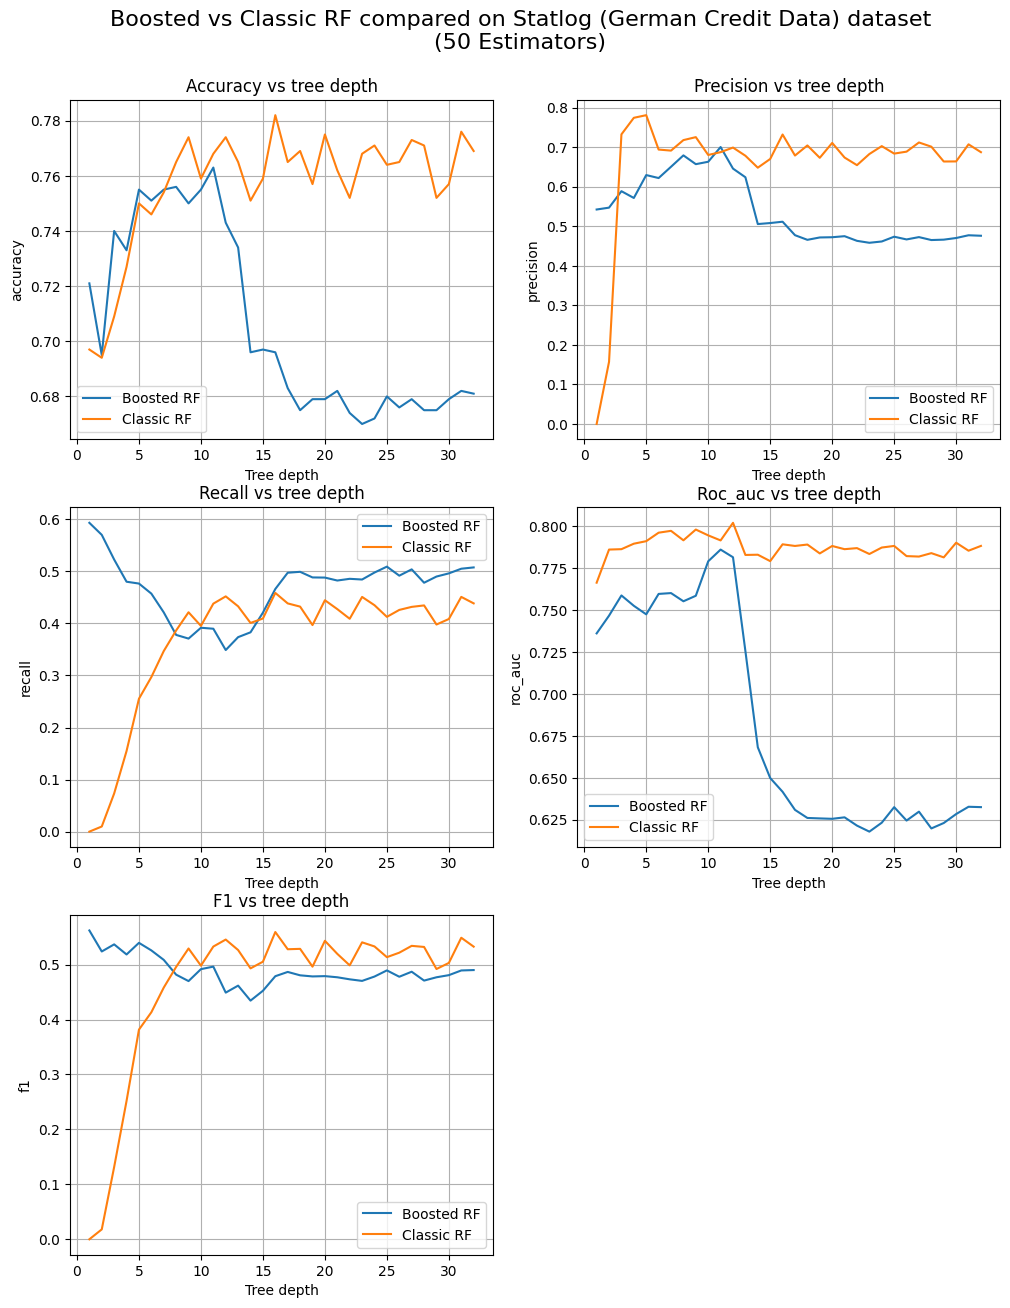

In [13]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(3, 2)
fig.set_size_inches(12, 15)
for measure, ax in zip(measures, axes.reshape(-1)):
    _y = [r[f"test_{measure}"] for r in res_statlog]
    _y_ref = [r[f"test_{measure}"] for r in res_ref_statlog]
    ax.plot(tree_depths, _y, label="Boosted RF")
    ax.plot(tree_depths, _y_ref, label="Classic RF")
    ax.set_xlabel("Tree depth")
    ax.set_ylabel(measure)
    ax.grid(True)
    ax.legend()
    ax.set_title(f"{measure.capitalize()} vs tree depth")
    fig.suptitle("Boosted vs Classic RF compared on Statlog (German Credit Data) dataset\n(50 Estimators)", fontsize=16, y=0.94)

axes.reshape(-1)[-1].set_visible(False)

plt.show()

Algorytm boostingowy może mieć przewagę, kiedy wykorzystywane są drzewa o ograniczonej ($n<10$ poziomów) głębokości - różnica widoczna jest przede wszystkim w wartościach miar odzysku i f1 - model ma tendencję do generowania fałszywie pozytywnych predukcji, jednak rezulatetem takiego zachowania jest wykrycie większej części prawdziwych pozytywów w zbiorze testwowym. Warto zwrócić uwagę na (niekiedy drastyczny) spadek jakości predykcji przy wzroście głębokości drzewa do 10-15 przykładów - dodatkowe skomplikowanie algorytmu prowadzi do przeuczenia modelu i spadku jakości predukcji.

#### Porównanie względem liczby drzew

Przyjeto rozmiar maksymalną głębokość drzewa $N=10$.

In [16]:
n_estimators = np.logspace(2, 9, base=2, dtype=np.int32)
measures = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']

In [28]:
res_breast_cancer = [evaluate(BoostedRFClassifier(
    estimator=DecisionTreeClassifier(max_depth=10),
    n_estimators=n,
    algorithm='SAMME',
    _disable_weights=True,
), X_breast_cancer, y_breast_cancer, scoring=measures) for n in n_estimators]
res_ref_breast_cancer = [evaluate(RandomForestClassifier(
    max_depth=10,
    n_estimators=n,
    n_jobs=8
), X_breast_cancer, y_breast_cancer, scoring=measures) for n in n_estimators]

In [17]:
res_spambase = [evaluate(BoostedRFClassifier(
    estimator=DecisionTreeClassifier(max_depth=10),
    n_estimators=n,
    algorithm='SAMME',
    _disable_weights=True,
), X_spambase, y_spambase, scoring=measures) for n in n_estimators]
res_ref_spambase = [evaluate(RandomForestClassifier(
    max_depth=10,
    n_estimators=n,
    n_jobs=8
), X_spambase, y_spambase, scoring=measures) for n in n_estimators]

In [18]:
res_statlog = [evaluate(BoostedRFClassifier(
    estimator=DecisionTreeClassifier(max_depth=10),
    n_estimators=n,
    algorithm='SAMME',
    _disable_weights=True,
), X_statlog, y_statlog, scoring=measures) for n in n_estimators]

In [19]:
res_ref_statlog = [evaluate(RandomForestClassifier(
    max_depth=10,
    n_estimators=n,
    n_jobs=8
), X_statlog, y_statlog, scoring=measures) for n in n_estimators]

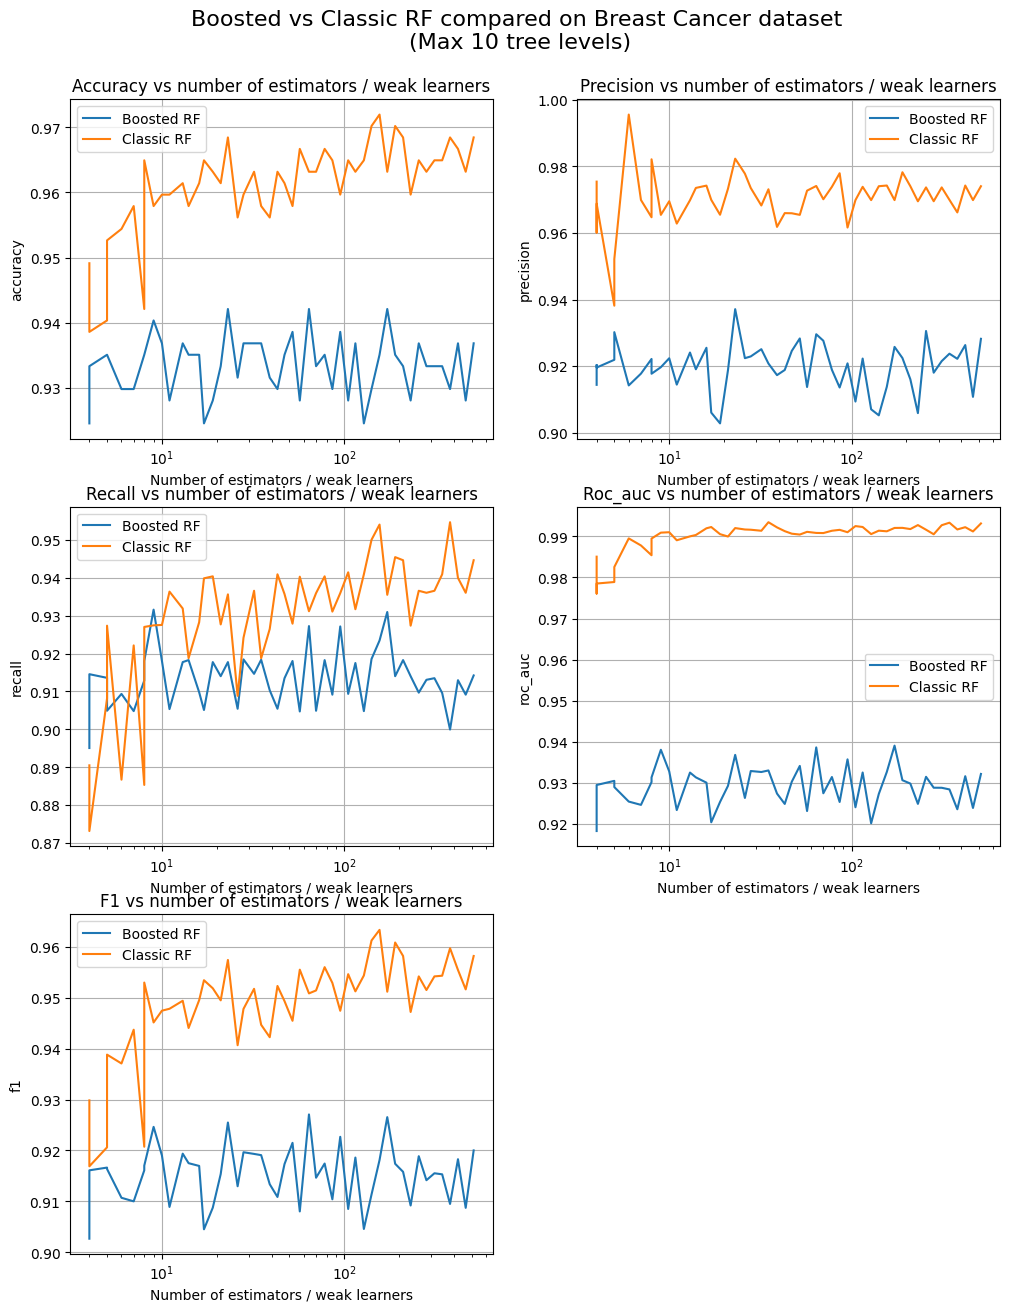

In [29]:
fig, axes = plt.subplots(3, 2)
fig.set_size_inches(12, 15)
for measure, ax in zip(measures, axes.reshape(-1)):
    _y = [r[f"test_{measure}"] for r in res_breast_cancer]
    _y_ref = [r[f"test_{measure}"] for r in res_ref_breast_cancer]
    ax.plot(n_estimators, _y, label="Boosted RF")
    ax.plot(n_estimators, _y_ref, label="Classic RF")
    ax.set_xlabel("Number of estimators / weak learners")
    ax.set_ylabel(measure)
    ax.set_xscale('log')
    ax.grid(True)
    ax.legend()
    ax.set_title(f"{measure.capitalize()} vs number of estimators / weak learners")
    fig.suptitle("Boosted vs Classic RF compared on Breast Cancer dataset \n(Max 10 tree levels)", fontsize=16, y=0.94)
axes.reshape(-1)[-1].set_visible(False)

plt.show()

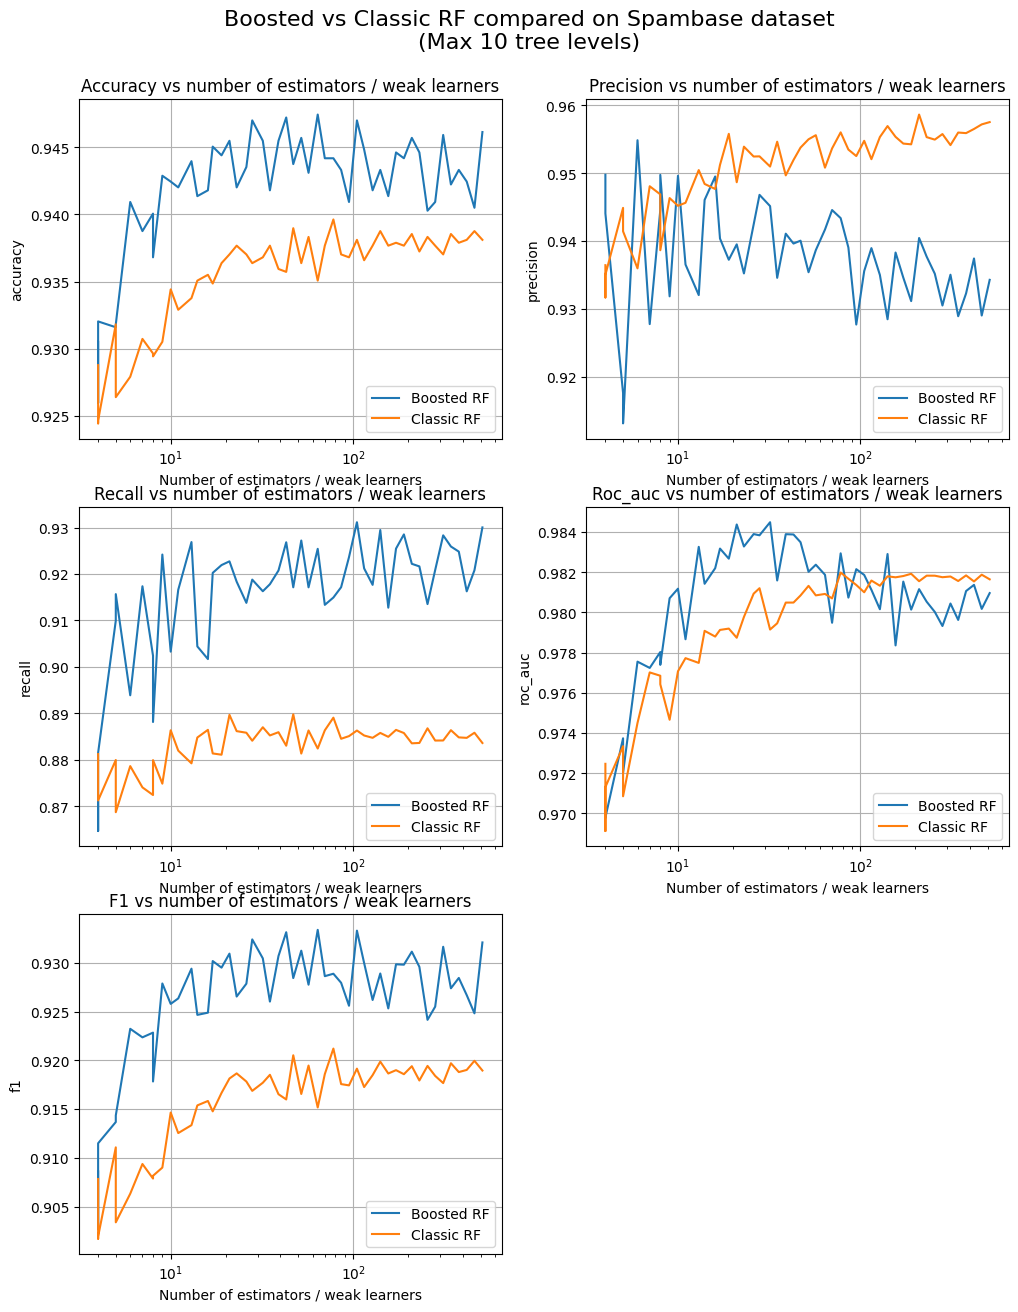

In [26]:
fig, axes = plt.subplots(3, 2)
fig.set_size_inches(12, 15)
for measure, ax in zip(measures, axes.reshape(-1)):
    _y = [r[f"test_{measure}"] for r in res_spambase]
    _y_ref = [r[f"test_{measure}"] for r in res_ref_spambase]
    ax.plot(n_estimators, _y, label="Boosted RF")
    ax.plot(n_estimators, _y_ref, label="Classic RF")
    ax.set_xlabel("Number of estimators / weak learners")
    ax.set_ylabel(measure)
    ax.set_xscale('log')
    ax.grid(True)
    ax.legend()
    ax.set_title(f"{measure.capitalize()} vs number of estimators / weak learners")
    fig.suptitle("Boosted vs Classic RF compared on Spambase dataset\n(Max 10 tree levels)", fontsize=16, y=0.94)
axes.reshape(-1)[-1].set_visible(False)

plt.show()

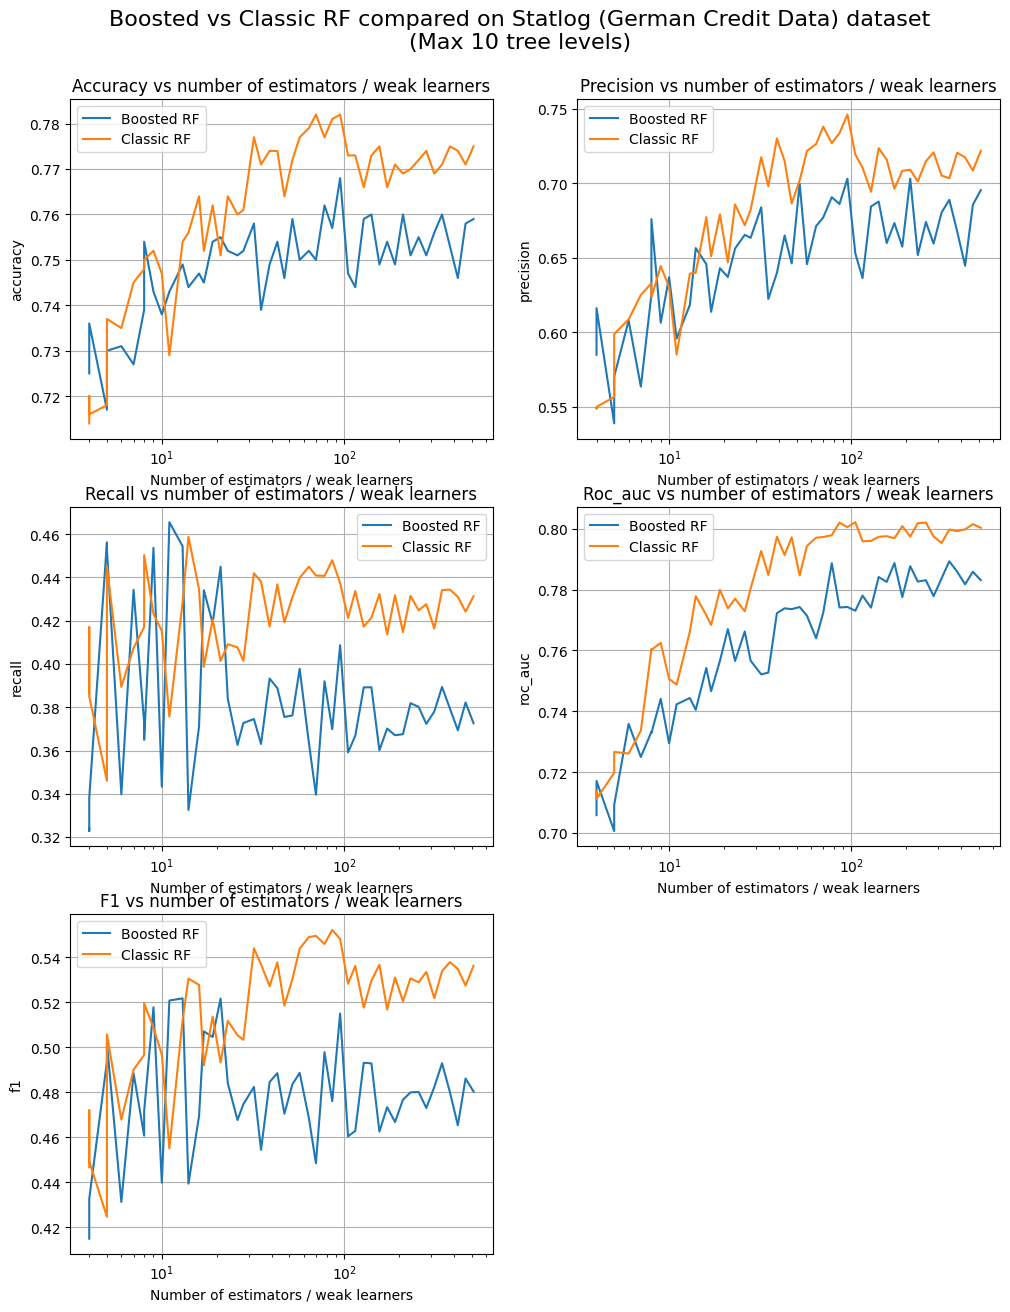

In [21]:
fig, axes = plt.subplots(3, 2)
fig.set_size_inches(12, 15)
for measure, ax in zip(measures, axes.reshape(-1)):
    _y = [r[f"test_{measure}"] for r in res_statlog]
    _y_ref = [r[f"test_{measure}"] for r in res_ref_statlog]
    ax.plot(n_estimators, _y, label="Boosted RF")
    ax.plot(n_estimators, _y_ref, label="Classic RF")
    ax.set_xlabel("Number of estimators / weak learners")
    ax.set_ylabel(measure)
    ax.set_xscale('log')
    ax.grid(True)
    ax.legend()
    ax.set_title(f"{measure.capitalize()} vs number of estimators / weak learners")
    fig.suptitle("Boosted vs Classic RF compared on Statlog (German Credit Data) dataset\n(Max 10 tree levels)", fontsize=16, y=0.94)

axes.reshape(-1)[-1].set_visible(False)

plt.show()

Przyrost jakości predykcji w przypadku algorytmy boostingowego jest na ogół wolniejszy, niż w przypadku algorytmu klasycznego - tym samym przewaga tego drugiego rośnie wraz z liczbą drzew. Co ciekawe, odwrotnie, niż w przypadku wzrostu głębokości drzewa, odzysk (a co za tym idzie - miara F1) nie ulega poprawie, za to polepsza się dokładność i precyzja - jest to zachowanie analogiczne do algorytmu AdaBoost, gdzie większa liczba słabych modeli na ogół pozytywanie wpływa na jakość predykcji.